<a href="https://colab.research.google.com/github/Blistt/Image-Retrieval/blob/main/ArtisticSimilarity_G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMAGE RETRIEVAL**

This notebook implements a very simple Content Based Image Retrieval (CBIR) system, that takes one image as a query, and outputs a set of similar images from a given database of images, ranked by their level of similarity to the query image. This system uses the VGG-19 architecture as a feature extractor to create embeddings for the images. Image-to-image similarity is computed on these embeddings.

<div align="center">
  <img src="illustrations/illustration1.png" alt="Art similarity illustration" width="400"><br>
  Figure 1. Which of the 2 images on the right is more similar to the one on the left? While image a) may have the same color palette, image b) has a highly similar composition.
</div>



**Loading Images**

The first step is loading the images. The VGG-19 architecture expects certain characteristics of an input image, such as the image being a tensor with shape (224 height, 224 width, 3 color channels), in a BGR scheme (as opposed to the typical RGB), etc. Fortunarely, with VGG-19 being a staple architecture in computer vision, Keras provides a pre-processing function that performs all the necessary transformations to get your images ready for passing through this network.
We will use this function when loading the images into our dataset.

In [33]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def load_images(path):
  path = Path(path)
  # Ensures only valid image files are loaded
  img_paths = list(path.glob('*.jpg')) + list(path.glob('*.jpeg')) + list(path.glob('*.png')) \
              + list(path.glob('*.gif'))
  images = []
  print(f'Loading {len(img_paths)} images')
  for img_path in tqdm(img_paths):
    # load image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    images.append(img)
  print('images loaded as' , type(images[0]), 'type')
  return images



def show_images(images, distances, pair_distances_img, pair_distances_emb, norm=False):
    # Display image in new window
    fig = plt.figure(figsize=(14, 8))

    # Normalizes all distances if norm is True
    if norm:
      distances = distances / np.max(distances)
      pair_distances_img = pair_distances_img / np.max(pair_distances_img)
      pair_distances_emb = pair_distances_emb / np.max(pair_distances_emb)

    for i in range(len(images)):
      ax = fig.add_subplot(1, len(images), i+1)
      if i == 0:
        ax.set_title('Query Image')
        # show distance
        ax.text(0.5, -0.1, f'VGG distance to query', ha='center', va='center', transform=ax.transAxes)
        # show pair distance img
        ax.text(0.5, -0.2, f'SSIM to image on the left', ha='center', va='center', transform=ax.transAxes)
        # show pair distance emb
        ax.text(0.5, -0.3, f'VGG distance to image on the left', ha='center', va='center', transform=ax.transAxes)
      if i >= 1:
        title = 'neighbor' + str(i)
        ax.set_title(title)
        # show distance
        ax.text(0.5, -0.1, f'{distances[i-1]:.2f}', ha='center', va='center', transform=ax.transAxes)
      if i >= 2:
        # show pair distance img
        ax.text(0.5, -0.2, f'{pair_distances_img[i-2]:.2f}', ha='center', va='center', transform=ax.transAxes)
        # show pair distance emb
        ax.text(0.5, -0.3, f'{pair_distances_emb[i-2]:.2f}', ha='center', va='center', transform=ax.transAxes)

      plt.imshow(np.squeeze(images[i]))
      plt.axis('off')
    plt.show()

We won't be performing any training in this system, as we will be leveraging a pre-trained model and identifying similar images in an unsupervised fashion through nearest neighbor search. Nonetheless, we selected a subset of images to use as queries to exemplify the results the system produces. We will call this subset of queries the *test* dataset and the remainder of the images as the *train* dataset.

For visualization purposes, we will make a copy of the dataset that won't go through VGG-19 pre-processing, so that we are able to look at the images in their original state. This strategy is not memory-efficient, but given the small size of our dataset, it is feasible.

In [ ]:
# Load 'test' dataset (query images)
test_path = 'data/test/'
test_images = load_images(test_path)

# Load 'train' dataset (candidate images to be retrieved)
train_path = 'D:/documents/anime/a-photos/'
train_images = load_images(train_path)

**Load model**

In this cell, we initialize the VGG-19 model with its pre-trained weights on the *ImageNet* dataset from TF directly. VGG-19 is a classifier model, which means it outputs a classification vector that tells us the class the image belongs to (e.g., cat, car, plane). 

However, we are not going to use it as a classifier. Instead, we are interested in the internal representation the network generates to arrive to such classifications. To that end, in this cell we also configure the model to output the activation maps of its convolutional layers, or so called *feature maps*, instead of the classification it makes.

In [ ]:
from keras import backend as K 

model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",)

model.summary()

layer_outputs = [layer.output for layer in model.layers[1:-1]]  # Identifies layer outputs
# Creates a model that will return the layer feature maps as outputs for a given image
visual_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs) 

layer_names = [layer.name for layer in visual_model.layers]

for i, layer in enumerate(layer_names):
    print(i, layer)

**Obtain feature maps**

In this cell we pass the entire dataset through our model, and obtain an embedding vector comprised of the *feature maps* produced by the convolutional layers of the network. 

It has been documented that different layers of the network encode information at differing scales and semantic complexity. For example, the earliest layers are said to encode small-scale and semantically simple information, such as textures (whether something is smooth, grainy, rugged, etc.). The deeper layers, on the other hand, given their larger receptive field (the spatial portion of the image each filter is informed by), can encode larger-scale information, such as the overall shapes of objects. Also, given how these layers are also informed by the encodings of the earliest layers, they are able to enconde information at increased semantic levels of complexity, which is what enables these last layers to discriminate between one object or many others, and produce a classification.

To visualize this, we confiture our *get_embeddings()* function to select how deep we want our *feature maps* to be, our if we want to aggregate multiple of them.

Lastly, if left as VGG-19 produces them, each feature in a *feature map* will include information about the spatial location of that feature in the image. We might not necessarily want this level of spatial precision when encoding image-to-image similarity. For example, if a feature is enconding the presence/absence of "fire" in an image, we really don't care whether the fire is in the left corner of both images or not, as long as both images contain fire (this is only an analogy, as deep learning features by themselves rarely align this well to human readable semantic concepts such as "fire"). To this end, we compute co-activation matrices, or Gram-matrices, that effectively remove the spatial specificity from the feature maps.

In [ ]:
def get_embeddings(f_levels, images):
  # Initialize embeddings
  E = []
  for i, img in enumerate(images):
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)       # Pre-processes image for VGG19
    # run an image through the network by making a prediction
    feature_maps = visual_model.predict(img)
    
    temp = np.zeros((0))
    for level in f_levels:
      A = feature_maps[level]
      # Flatten feature map to 2x2 matrix if it is 4D (e.g. Conv layer)
      if len(A.shape) == 4:
        A = A.reshape(A.shape[0], A.shape[1]*A.shape[2], A.shape[3], order='F')
        A = A.reshape(A.shape[1], A.shape[2])
        # Compute Gram matrix (cummulative co-activation of filter per layer)
        G = np.matmul(np.transpose(A),A)
        # Append this layer's flattened Gram matrix to images embedding
        dummy = np.zeros(temp.shape[0] + G.flatten().shape[0])
        dummy[:temp.shape[0]] = temp
        dummy[temp.shape[0]:] = G.flatten()
        emb = np.copy(dummy) 
      # Flatten feature map to 1D vector if it is 2D (e.g. FC layer)
      else:
        emb = np.copy(A.flatten())

    E.append(np.copy(emb))

    if i%10 == 0:
      print(f'Gettings embedding of img no. {i}, with shape {E[i].shape}, and {len(f_levels)} layers')
    
  return np.array(E)


# Select the layer from which to extract feature maps (conv1_1 is layer 0)
f_levels = [23]        # Choose from [1,4,9,14,19,22,23]

# Get embeddings for 'test' dataset
test_E = get_embeddings(f_levels, test_images)

# Get embeddings for 'train' dataset
train_E = get_embeddings(f_levels, train_images)

**Create list of neighbors**

Once we get embeddings for all of our images, we can encode image-to-image similarity via simple nearest neighbor search. We will use SciKit learn's implementation of knn, which identifies the set of *k* nearest neighbors for each image in the dataset.

In [ ]:
# Fit KNN model to train embeddings
knnbr = NearestNeighbors(n_neighbors = 6, algorithm = 'ball_tree').fit(train_E)   

**Implement Content Based Image Retreival System**

Finally, we are ready to implement the entire Image Retrieval system. 
- We first select the layers to use for our *feature maps*
- We then initialize an array that will contain our testing/query images
- We use the *get_embeddings()* function to get the embeddings for ALL our images (testing and training)
- We identify the *k* nearest neighbors for each of our query images

In [27]:
def get_knn_for_query(e, knnbr, train_images, train_embeddings):
  # Get the neighbors of the query image
  knn = knnbr.kneighbors(e)
            
  # GETS THE IMAGES OF THE KNN
  knn_images = []
  # Retrieve the k nearest neighbor images of the query image 
  for i in knn[1][0]:
    knn_images.append(train_images[i])

  # GETS THE EMBEDDINGS OF THE KNN
  knn_E = []
  # Retrieve the k nearest neighbor embeddings of the query image 
  for i in knn[1][0]:
    knn_E.append(train_embeddings[i])

  distances = knn[0][0]

  return knn_images, knn_E, distances

These are the 5 nearest neighbors of the first 25 query images. 

**Note:** *These are randomized, so if you run the notebook again, these will be the first 25 results.*

In [ ]:
from skimage.metrics import structural_similarity as ssim

def get_query_distances(query_results, type='image'):

    query_distances = []
    
    # get the pairwise distances between the query results
    for i in range(1, len(query_results)):
        if type == 'image':
            # get SSIM distance
            pairwise_distance = ssim(np.array(query_results[i]), np.array(query_results[i-1]), channel_axis=-1)
        else:
            pairwise_distance = np.linalg.norm(query_results[i] - query_results[i-1])
        
        query_distances.append(pairwise_distance)
    
    return query_distances

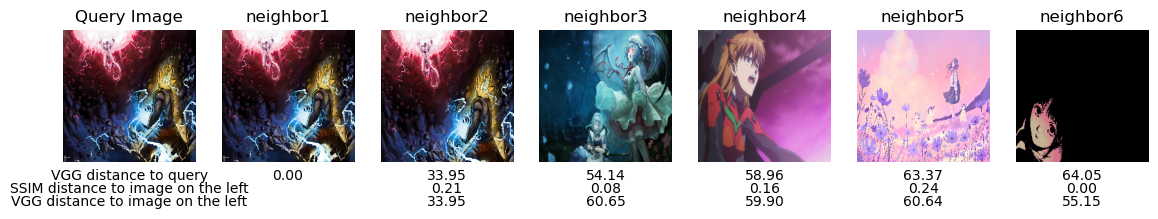

Distances: [ 0.         33.94941799 54.13661595 58.95768796 63.3716046  64.05015176]


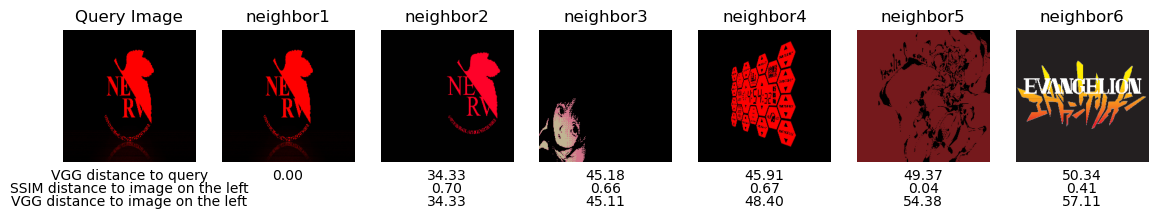

Distances: [ 0.         34.3314649  45.17834629 45.91419847 49.36805442 50.34206882]


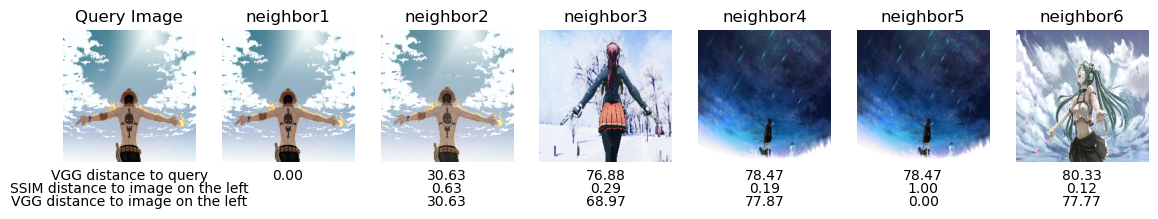

Distances: [ 0.         30.63326622 76.87949038 78.47236945 78.47236945 80.33096325]


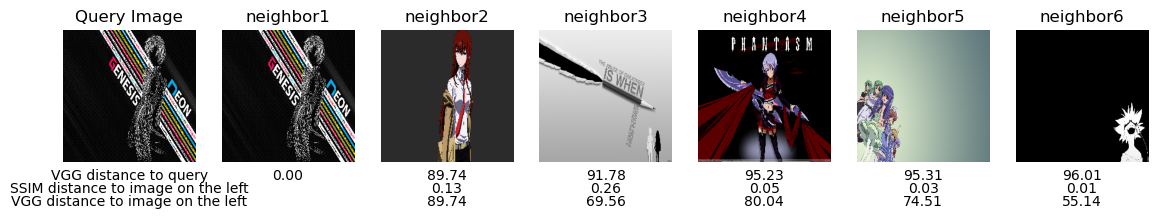

Distances: [ 0.         89.74072304 91.77873159 95.23073931 95.30604427 96.00895792]


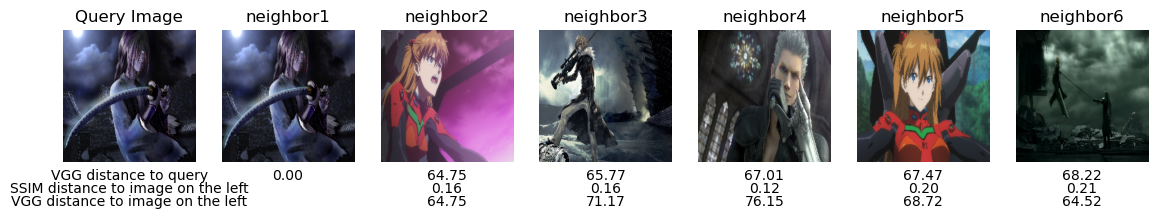

Distances: [ 0.         64.7542948  65.76855722 67.01391572 67.46921219 68.2209947 ]


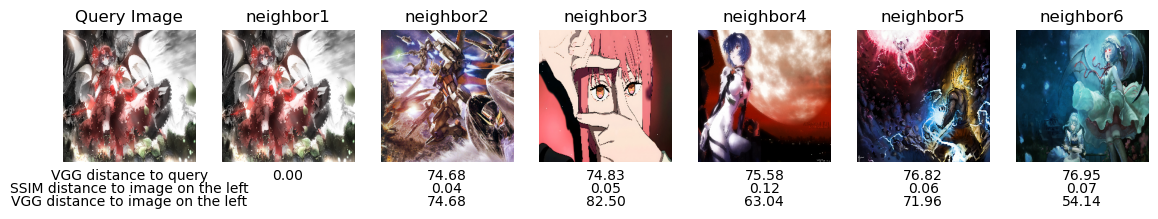

Distances: [ 0.         74.67910052 74.83254348 75.58133419 76.81671388 76.94554075]


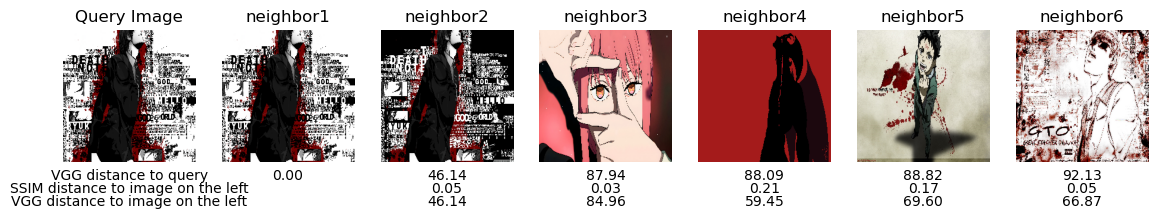

Distances: [ 0.         46.13705595 87.9354876  88.08659855 88.81875479 92.13491576]


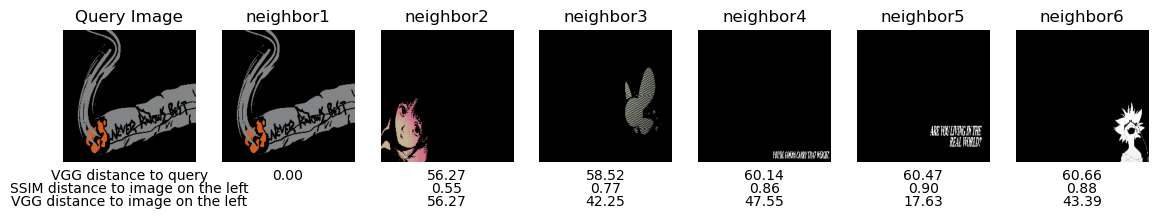

Distances: [ 0.         56.26978345 58.51934884 60.13807363 60.47029122 60.66126236]


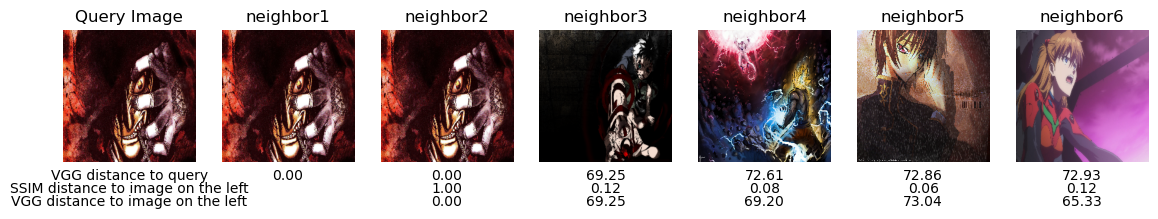

Distances: [ 0.          0.         69.25338332 72.61264249 72.86458037 72.93477293]


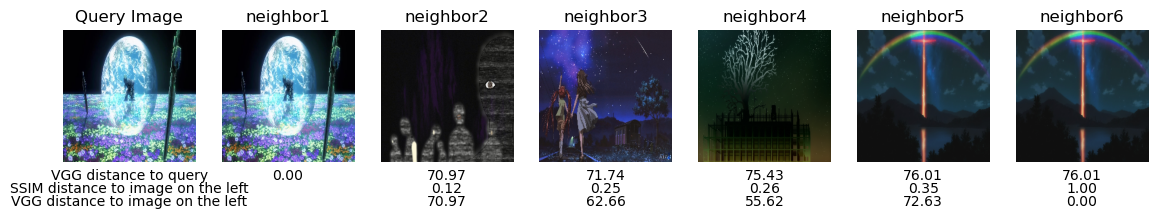

Distances: [ 0.         70.96733371 71.73870991 75.43473182 76.00800169 76.00800169]


Distances: [ 0.         63.64689107 65.1355413  65.61756228 66.124353   67.11278743]


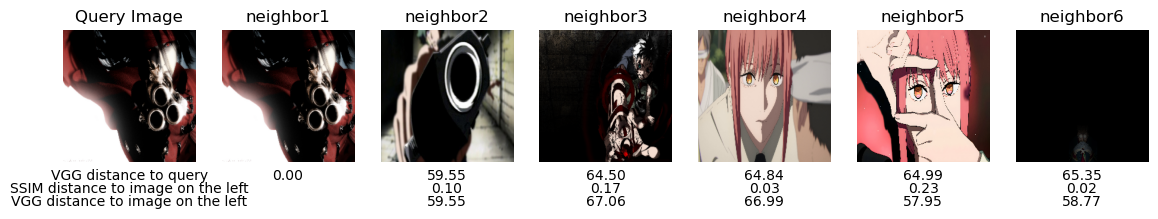

Distances: [ 0.         59.55200257 64.49733955 64.83584382 64.99069276 65.34635735]


Distances: [ 0.         80.20235746 80.93193209 81.36271567 83.19261654 83.73025672]


Distances: [ 0.         64.91523894 65.98638326 66.01476073 66.36561684 66.51123133]


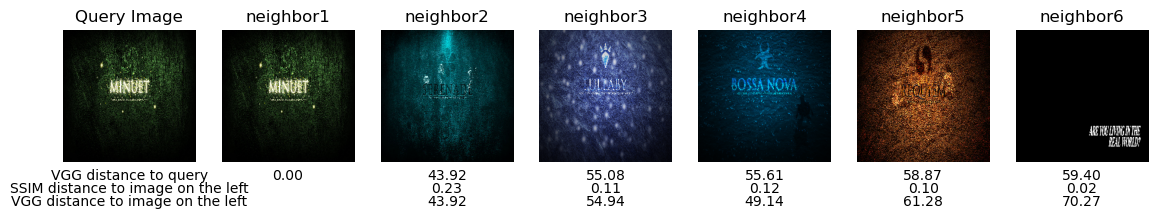

Distances: [ 0.         43.9155698  55.07658374 55.61133426 58.86803659 59.39952907]


Distances: [ 0.         55.62780981 57.61289472 58.56265304 58.70663603 59.01752492]


Distances: [ 0.         63.44662098 67.00411629 67.93589931 68.10095854 68.43489857]


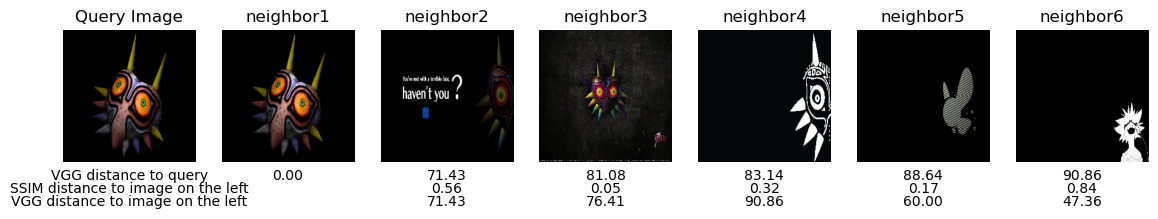

Distances: [ 0.         71.42588915 81.08100747 83.14362268 88.64281811 90.85749486]


Distances: [ 0.         75.61088047 77.60226207 77.67359849 77.81451328 78.74564228]


Distances: [ 0.         63.60072235 64.2954025  67.71632306 68.92011556 69.19048221]


Distances: [ 0.         80.09593538 83.89416869 84.15313629 84.27635489 84.35859382]


Distances: [ 0.         19.72120656 57.4392673  63.13470301 63.57450927 65.20745491]


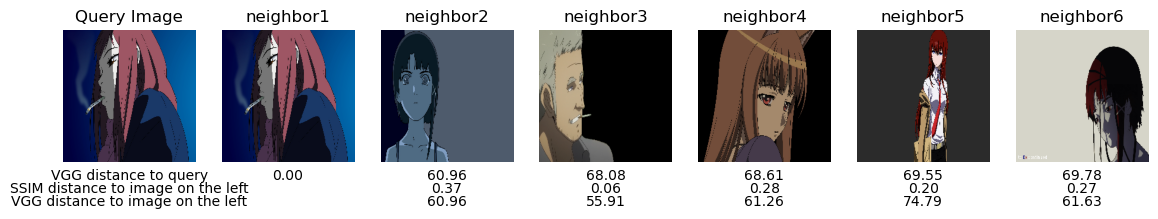

Distances: [ 0.         60.96045222 68.07771816 68.61091461 69.54533771 69.77563678]


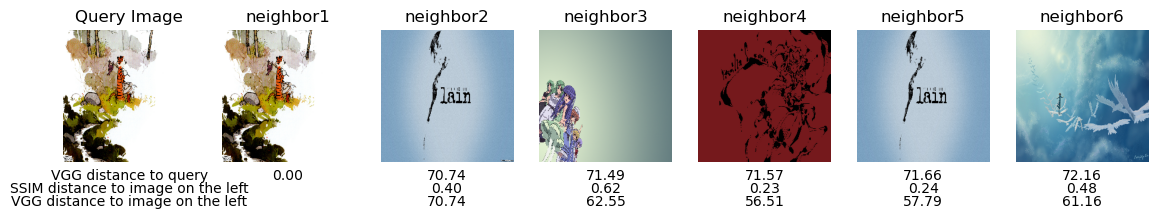

Distances: [ 0.         70.74390682 71.49366428 71.5698162  71.66318807 72.15636191]


Distances: [ 0.         86.38902986 88.52762163 89.69960433 89.69960433 89.73250442]


Distances: [ 0.         74.56949484 75.25225626 75.58468207 76.30958737 77.5683809 ]


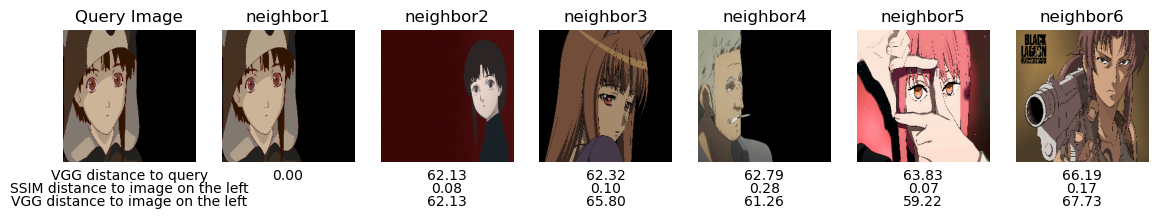

Distances: [ 0.         62.13439366 62.32432135 62.78746592 63.82804589 66.18901258]


Distances: [ 0.         64.06091745 64.06091745 68.00422195 68.0771395  68.09969646]


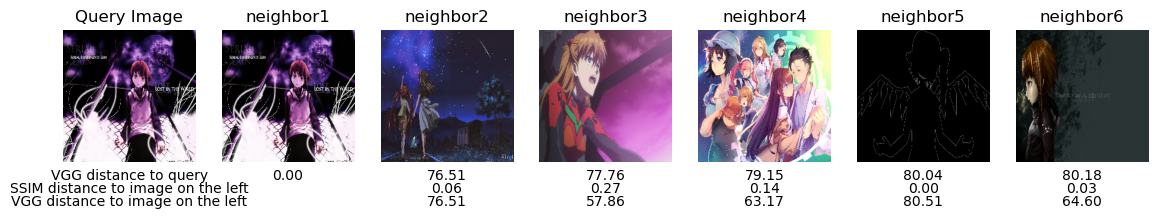

Distances: [ 0.         76.50859346 77.76250862 79.15248268 80.03732016 80.18191457]


Distances: [ 0.         97.47983179 97.58393641 97.74177145 98.25783749 98.59295585]


Distances: [ 0.         64.9311293  69.76078231 72.51605604 74.31958652 74.67861156]


Distances: [ 0.         23.42417563 61.18718556 61.84415704 63.98978312 64.42672595]


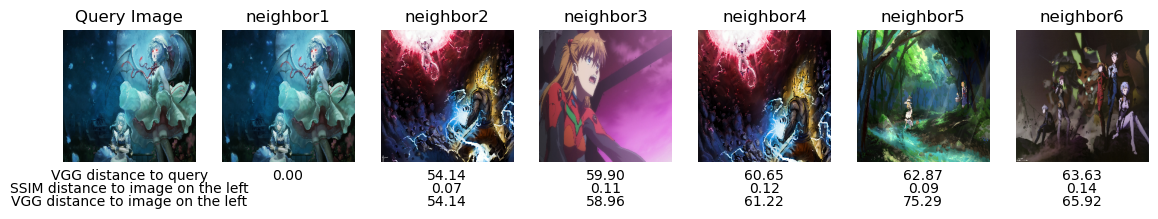

Distances: [ 0.         54.13661595 59.89716738 60.6502759  62.8698576  63.63060143]


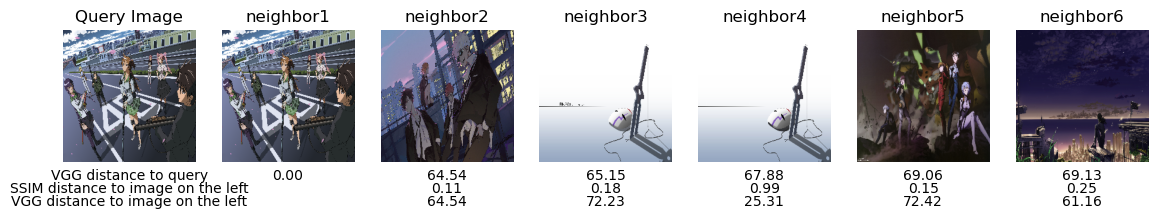

Distances: [ 0.         64.53514786 65.15303723 67.88476204 69.06271    69.12880322]


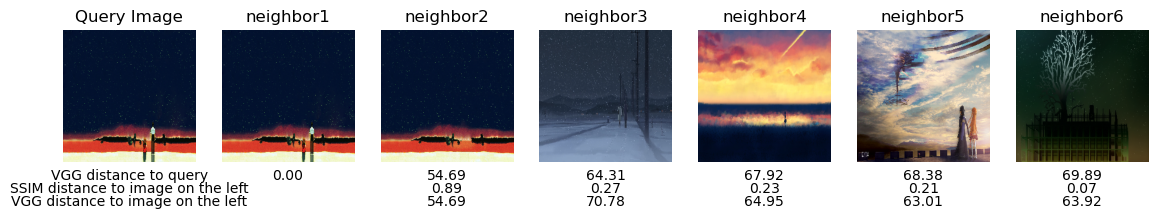

Distances: [ 0.         54.68886761 64.31041773 67.92074423 68.37853503 69.89163582]


Distances: [ 0.         59.7820509  60.18359502 60.72700215 61.50952298 62.16831852]


In [32]:
knn_images = []
# Iterate through all test images (last 'test_size' images of dataset)
for i in range(test_E.shape[0]):
    img = test_images[i]
    e = test_E[i].reshape(1, -1)
    knn_images, knn_E, distances = get_knn_for_query(e, knnbr, train_images, train_E)

    pair_distances_img = get_query_distances(knn_images, type='image')
    pair_distances_emb = get_query_distances(knn_E, type='embedding')


    # show the results
    result = [img] + knn_images
    show_images(result, distances, pair_distances_img, pair_distances_emb, norm=False)
    print('Distances:', distances)

**Input your own image**

To input your own image, replace the image in the `test_image/` directory with your own input image. Running this cell will give you the 5 nearest neighbors. Change the K parameter to get as many neighbors as you see fit.

In [ ]:
img_path = 'test_image/'
test_image = []
view_test_image = []

# Load query image
img = load_images(img_path)

# Select the layer from which to extract feature maps 
f_levels = [23]         # Choose from [1,4,9,14,19,22,23]
# Get the embeddings of the query image
e = get_embeddings(f_levels, img)

result = get_knn_for_query(img[0], e, knnbr, train_images)

# Show the results
show_images(result, '1')

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


- Improve layer selection criteria (last conv layer of block instead of first one) [30 mins]
- filter out duplicates [1 hrs]
- Modularize for app instead of notebook [2 hrs]

- Add UI
- host ui